# 8.5 Introduction to generative adversarial networks

GANs, introduced in 2014 by [Goodfellow et al](https://arxiv.org/abs/1406.2661), are an alternative to VAEs for learning latent spaces of images. They enable the generation of fairly realistic synthetic images by forcing the generated images to be **statistically** almost indistinguishable from real ones. 

A GAN is: a forger network, trying to make fake images, and an expert network, spotting the fake images, each being trained to best the other. As such, a GAN is made of two parts:
- *Generator network*: Takes as input a random vector (a random point in the latent space), and decodes it into a synthetic image. 
- *Discriminator network (or adversary)*: Takes as input an image (real or synthetic), and predicts whether the image came from the training set or was created by the generator network. 

The generator network is trained to be able to fool the discriminator network, and thus it evolves toward generating increasingly realistic images as training goes on: artificial images that look indistinguishable from real ones, to the extent that it’s impossible for the discriminator network to tell the two apart. Meanwhile, the discriminator is constantly adapting to the gradually improving capabilities of the generator, setting a high bar of realism for the generated images. Once training is over, the generator is capable of turning any point in its input space into a believable image. Unlike VAE s, this latent space has fewer explicit guarantees of meaningful structure; in particular, it isn’t continuous.

Remarkably, a GAN is a system where the optimization minimum isn’t fixed. Normally, gradient descent consists of rolling down hills in a static loss landscape. But with a GAN , every step taken down the hill changes the entire landscape a little. It’s a dynamic system where
the optimization process is seeking not a minimum, but an equilibrium between two forces. For this reason, GANs are notoriously difficult to train. Getting a GAN to work requires lots of careful tuning of the model architecture and training parameters.

## 8.5.1 A schematic GAN implementation

In this section, we'll explain how to implement a GAN in Keras, in its barest form. The specific implementation is a *deep convolutions GAN* (DCGAN): a GAN where the generator and discriminator are deep convnets. In particular, it uses a `Conv2DTranspose` layer for image upsampling in the generator. 

You’ll train the GAN on images from CIFAR10 , a dataset of 50,000 32 × 32 RGB images belonging to 10 classes (5,000 images per class). To make things easier, we’ll
only use images belonging to the class “frog”. Schematically, the GAN looks like this:
1. A `generator` network maps vectors of shape `(latent_dim, )` to images of shape `(32, 32, 3)`.
2. A `discriminator` network maps images of shape `(32, 32, 3)` to a binary score estimating the prob. that the image is real.
3. A `gan` network chains the generator and the discriminator together: `gan(x) = discriminator(generator(x))`. Thus this `gan` network maps latent space vectors to the discriminator's assessment of the realism of these latent vectors as decoded by the generator. 
4. We train the discriminator using examples of real and fake images along with "real"/"fake" labels, just as we train any regular image-classification model.
5. To train the generator, we use the gradients of the generator's weights with regard to the loss of the `gan` model. This means, at every step, you move the weights of the generator in a direction that makes the discriminator more likely to classify as "real" the images decoded by the generator. In other words, you train the generator to fool the discriminator.

## 8.5.2 A bag of tricks

The process of training GANs and tuning GAN implementations is notoriously difficult. There are a number of known tricks you should keep in mind. Like most things in deep learning, it’s more alchemy than science: these tricks are heuristics, not theory-backed guidelines. They’re supported by a level of intuitive understanding of the phenomenon at hand, and they’re known to work well empirically, although not necessarily in every context.

Here are a few of the tricks used in the implementation of the GAN generator and discriminator in this section. It isn’t an exhaustive list of GAN-related tips; you’ll find many more across the GAN literature:
- We use `tanh` as the last activation in the generator, instead of `sigmoid`, which is more commonly found in other types of models.
- We sample points from the latent space using a *normal distribution* (Gaussian distribution), not a uniform distribution.
- Stochasticity is good to induce robustness. Because GAN training results in a dynamic equilibrium, GANs are likely to get stuck in all sorts of ways. Introducing randomness during training helps prevent this. We introduce randomness in two ways: by using dropout in the discriminator and by adding random noise to the labels for the discriminator.
- Sparse gradients can hinder GAN training. In deep learning, sparsity is often a desirable property, but not in GANs. Two things can induce gradient sparsity:
max pooling operations and `ReLU` activations. Instead of max pooling, we recommend using strided convolutions for downsampling, and we recommend using a `LeakyReLU` layer instead of a `ReLU` activation. It’s similar to ReLU , but it relaxes sparsity constraints by allowing small negative activation values
- In generated images, it’s common to see checkerboard artifacts caused by unequal coverage of the pixel space in the generator. To fix this, we use a kernel size that’s divisible by the stride size whenever we use a
strided `Conv2DTranpose` or `Conv2D` in both the generator and the discriminator.

## 8.5.3 The generator

First, let's develop a `generator` model that turns a vector (from the latent space; during training it will be sampled at random) into a candidate image. One of the many issues that commonly arise with GANs is that the generator gets stuck with generated images that look like noise. A possible solution is to use dropout on both the discriminator and the generator. 

### L8.29 GAN generator network

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


In [4]:
cd /gdrive/My Drive/kaggle/

/gdrive/My Drive/kaggle


In [5]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [6]:
!pip install keras==2.0.8

     |████████████████████████████████| 276kB 4.7MB/s 
ERROR: textgenrnn 1.4.1 has requirement keras>=2.1.5, but you'll have keras 2.0.8 which is incompatible.
  Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1


In [7]:
import tensorflow
print(tensorflow.__version__)

1.15.2


In [8]:
import keras
from keras import layers
import numpy as np

latent_dim = 32
height = 32
width = 32
channels = 3

generator_input = keras.Input(shape=(latent_dim, ))

# transforms the input into a 16x16 128-channel feature map
x = layers.Dense(128 * 16 * 16)(generator_input)
x = layers.LeakyReLU()(x)
x = layers.Reshape((16, 16, 128))(x)

x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

# Upsamples to 32x32
x = layers.Conv2DTranspose(256, 4, strides=2, padding='same')(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

# produces a 32x32 1-channel feature map (shape of a CIFAR10 image)
x = layers.Conv2D(channels, 7, activation='tanh', padding='same')(x)
# instantiates the generator model, which maps the input of shape
# (latent_dim, ) into an image of shape (32, 32, 3)
generator = keras.models.Model(generator_input, x)
generator.summary()

Using TensorFlow backend.





_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32768)             1081344   
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32768)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 256)       819456    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 256)       1048832   
_______

In [0]:
from keras.utils import plot_model
plot_model(generator, show_shapes=True)

## The discriminator

Now, we’ll develop a `discriminator` model that takes as input a candidate image (real or synthetic) and classifies it into one of two classes: “generated image” or “real image that comes from the training set”.

### L8.30 The GAN discriminator network

In [10]:
discriminator_input = layers.Input(shape=(height, width, channels))
x = layers.Conv2D(128, 3)(discriminator_input)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Flatten()(x)

# one dropout layer; an important trick
x = layers.Dropout(0.4)(x)

# classification layer
x = layers.Dense(1, activation='sigmoid')(x)

# instantiates the discriminator model, which turns a (32, 32, 3) input into a 
# binary classification decision (fake/real)
discriminator = keras.models.Model(discriminator_input, x)
discriminator.summary()

discriminator_optimizer = keras.optimizers.RMSprop(lr=0.0008, 
                                                   clipvalue=1.0, 
                                                   decay=1e-8) #to stabilize traning

discriminator.compile(optimizer=discriminator_optimizer, 
                      loss='binary_crossentropy')

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 30, 30, 128)       3584      
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)   

## 8.5.5 The adversarial network

Finally, we’ll set up the GAN , which chains the generator and the discriminator. When trained, this model will move the generator in a direction that improves its ability to fool the discriminator. This model turns latent-space points into a classification
decision—“fake” or “real”, and it’s meant to be trained with labels that are always “these are real images.” So, training `gan` will update the weights of `generator` in a way that makes `discriminator` more likely to predict “real” when looking at fake images. It’s very important to note that you set the discriminator to be frozen during training (non-trainable): its weights won’t be updated when training `gan`. If the discriminator 
weights could be updated during this process, then you’d be training the discriminator to always predict “real,” which isn’t what we want.

### L8.31 Adversarial network

In [0]:
# Sets discriminator weights to non-trainable (this will only apply to the gan model)
discriminator.trainable = False

gan_input = keras.Input(shape=(latent_dim, ))
gan_output = discriminator(generator(gan_input))
gan = keras.models.Model(gan_input, gan_output)

gan_optimizer = keras.optimizers.RMSprop(lr=0.0004, 
                                         clipvalue=1.0, 
                                         decay=1e-8)
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')

## How to train the DCGAN

### L8.32 Implementing GAN training

In [21]:
import os
from keras.preprocessing import image

(x_train, y_train), (_, _) = keras.datasets.cifar10.load_data()

# selects images from class 6 (frog)
x_train = x_train[y_train.flatten() == 6]

x_train = x_train.reshape((x_train.shape[0], ) + 
                          (height, width, channels)).astype('float32') / 255.

iterations = 10000
batch_size = 20
save_dir = 'GAN'

start = 0
for step in range(iterations):
  # samples random points in the latent space
  random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

  # decodes them to fake images
  generated_images = generator.predict(random_latent_vectors)

  # combines them with real images
  stop = start + batch_size
  real_images = x_train[start: stop]
  combined_images = np.concatenate([generated_images, real_images])

  # assemble labels, discriminating real from fake images
  labels = np.concatenate([np.ones((batch_size, 1)), 
                           np.zeros((batch_size, 1))])
  
  # add random noise to the labels, an important TRICK.
  labels += 0.05 * np.random.random(labels.shape)

  # trains the discriminator
  d_loss = discriminator.train_on_batch(combined_images, labels)

  # samples random points in the latent space
  random_latent_vectors = np.random.normal(size=(batch_size, 
                                                 latent_dim))
  
  # assembles labels that say "these are all real images" (it's a lie!)
  misleading_targets = np.zeros((batch_size, 1))

  # trains the generator (via the gan model, where the discriminator weights are frozen)
  a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets)

  start += batch_size
  if start > len(x_train) - batch_size:
    start = 0

  # occasionally saves and plots (every 100 steps) 
  if step % 100 == 0:
    gan.save_weights('gan.h5')

    print('discriminator loss: {}'.format(d_loss))
    print('adversarial loss: {}'.format(a_loss))

    # saves one generated image
    img = image.array_to_img(generated_images[0] * 255., scale=False)
    img.save(os.path.join(save_dir, 
                          'generated_frog' + str(step) + '.png'))
    
    img = image.array_to_img(real_images[0] * 255., scale=False)
    img.save(os.path.join(save_dir, 
                          'real_frog' + str(step) + '.png')) 

discriminator loss: 1.1337556838989258
adversarial loss: 5.331881999969482
discriminator loss: 0.6345791220664978
adversarial loss: 1.2023367881774902
discriminator loss: 0.6985601186752319
adversarial loss: 0.818198025226593
discriminator loss: 0.717503547668457
adversarial loss: 0.7684839367866516
discriminator loss: 0.7002662420272827
adversarial loss: 0.7855768799781799
discriminator loss: 0.6834627389907837
adversarial loss: 0.7610622644424438
discriminator loss: 0.6931406259536743
adversarial loss: 0.8459066152572632
discriminator loss: 0.6818028688430786
adversarial loss: 0.7179139256477356
discriminator loss: 0.8216263055801392
adversarial loss: 0.7926645278930664
discriminator loss: 0.6945410966873169
adversarial loss: 0.7580620050430298
discriminator loss: 0.6977667808532715
adversarial loss: 0.7291161417961121
discriminator loss: 0.6920585632324219
adversarial loss: 0.7419438362121582
discriminator loss: 0.6918503046035767
adversarial loss: 0.7600604295730591
discriminator l

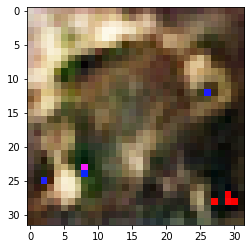

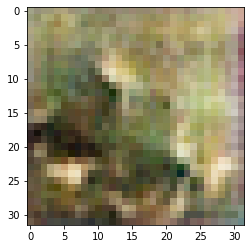

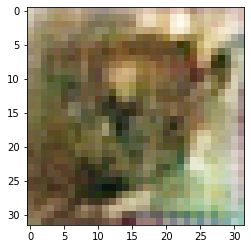

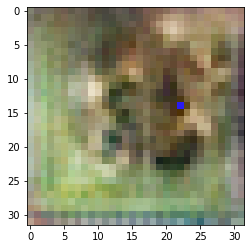

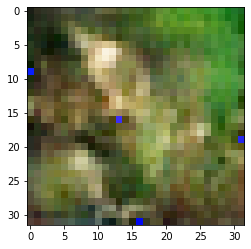

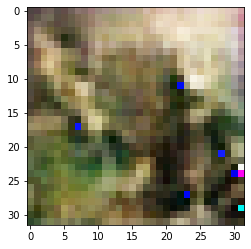

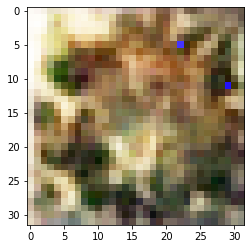

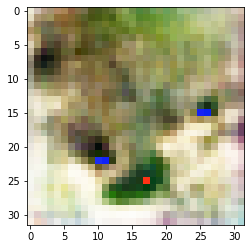

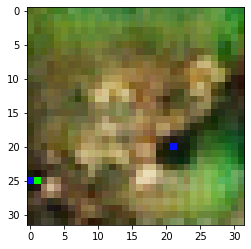

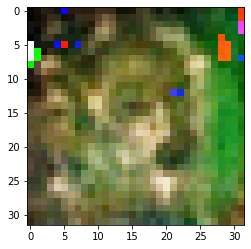

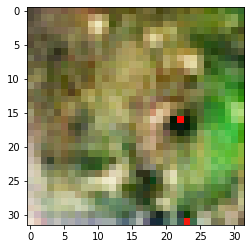

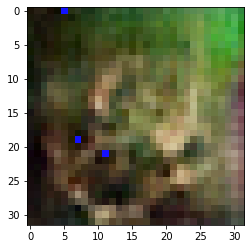

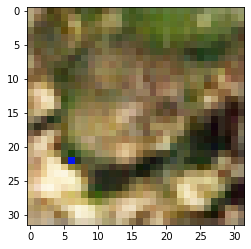

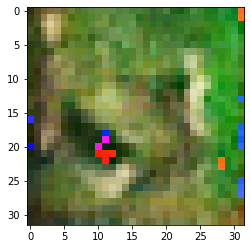

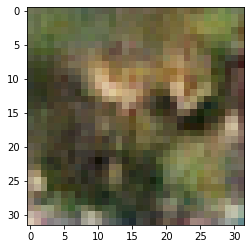

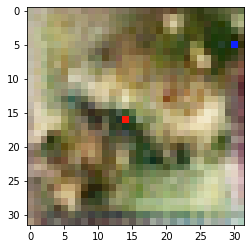

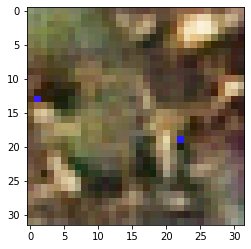

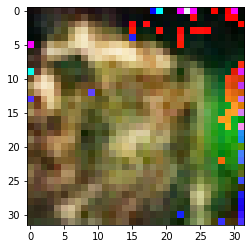

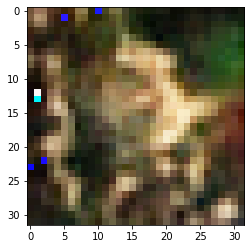

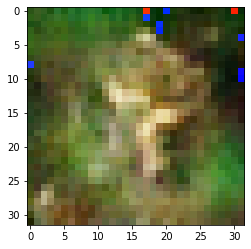

In [22]:
import matplotlib.pyplot as plt

# sample random points in the latent space
ramdom_latent_vectors = np.random.normal(size=(10, latent_dim))

# decode them to fake images
generated_images = generator.predict(random_latent_vectors)

for i in range(generated_images.shape[0]):
  img = image.array_to_img(generated_images[i] * 255., scale=False)
  plt.figure()
  plt.imshow(img)

plt.show()

## Wrapping up
- A GAN consists of a generator network coupled with a discriminator network. The discriminator is trained to differenciate between the output of the generator
and real images from a training dataset, and the generator is trained to fool the discriminator. Remarkably, the generator nevers sees images from the training set directly; the information it has about the data comes from the discriminator.
- GAN s are difficult to train, because training a GAN is a dynamic process rather than a simple gradient descent process with a fixed loss landscape. Getting a
GAN to train correctly requires using a number of heuristic tricks, as well as extensive tuning.
- GANs can potentially produce highly realistic images. But unlike VAEs, the latent space they learn doesn’t have a neat continuous structure and thus may not be suited for certain practical applications, such as image editing via latent-space concept vectors.